In [41]:
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

from sklearn import *
from lightgbm import LGBMRegressor

In [84]:
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

In [85]:
val_id = ((train.year == 2017) & (train.month >= 3))
trn_id = ~val_id
print('val ratio:', f'{len(train.loc[val_id])/len(train):.2%}')

val ratio: 15.10%


In [176]:
nn_col = [
    'min_visitors',
    'mean_visitors',
    'median_visitors',
    'max_visitors',
    'count_observations',
    'latitude',
    'longitude',
    'rs1_x',
    'rv1_x',
    'rs2_x',
    'rv2_x',
    'rs1_y',
    'rv1_y',
    'rs2_y',
    'rv2_y',
    'total_reserv_sum',
    'total_reserv_mean',
    'total_reserv_dt_diff_mean',
    'date_int',
    'var_max_lat',
    'var_max_long',
    'lon_plus_lat',
]

cat_col = [
    'holiday_flg'
    'dow',
    'year',
    'month',
    'day_of_week',
    'air_genre_name',
    'air_area_name',
    'air_store_id2',
]

all_col = nn_col + cat_col

In [177]:
from keras.layers import Input, Embedding, Dense

In [ ]:
def get_model(train, hidden1_neurons=35, hidden2_neurons=15):
    K.clear_session()
    air_store_id2 = Input(shape=(1,), dtype='int32', name='air_store_id2')
    air_store_id2_emb = Embedding(len(train['air_store_id2'].unique()), 15, name='air_store_id_emb')(air_store_id2)
    air_store_id2_emb = keras.layers.Flatten(name='air_store_id_emb_flatten')(air_store_id2_emb)

    dow = Input(shape=(1,), dtype='int32', name='dow')
    dow_emb = Embedding(8, 3, name='dow_emb')(dow)
    dow_emb = keras.layers.Flatten(name='dow_emb_flatten')(dow_emb)

    month = Input(shape=(1,), dtype='int32', name='month')
    month_emb = Embedding(13, 3, name='month_emb')(month)
    month_emb = keras.layers.Flatten(name='month_emb_flatten')(month_emb)

    air_area_code = Input(shape=(1,), dtype='int32', name='air_area_name')
    air_area_code_emb = Embedding(len(train['air_area_name'].unique()), 8, input_shape=(1,), name='air_area_code_emb')(air_area_code)
    air_area_code_emb = keras.layers.Flatten(name='air_area_code_emb_flatten')(air_area_code_emb)
    
    air_genre_code = Input(shape=(1,), dtype='int32', name='air_genre_name')
    air_genre_code_emb = Embedding(len(train['air_genre_name'].unique()), 5, input_shape=(1,),
                                   name='air_genre_code_emb')(air_genre_code)
    air_genre_code_emb = keras.layers.Flatten(name='air_genre_code_emb_flatten')(air_genre_code_emb)
    
    holiday_flg = Input(shape=(1,), dtype='float32', name='holiday_flg')
    year = Input(shape=(1,), dtype='float32', name='year')
    min_visitors = Input(shape=(1,), dtype='float32', name='min_visitors')
    mean_visitors = Input(shape=(1,), dtype='float32', name='mean_visitors')
    median_visitors = Input(shape=(1,), dtype='float32', name='median_visitors')
    max_visitors = Input(shape=(1,), dtype='float32', name='max_visitors')
    count_observations = Input(shape=(1,), dtype='float32', name='count_observations')
    rs1_x = Input(shape=(1,), dtype='float32', name='rs1_x')
    rv1_x = Input(shape=(1,), dtype='float32', name='rv1_x')
    rs2_x = Input(shape=(1,), dtype='float32', name='rs2_x')
    rv2_x = Input(shape=(1,), dtype='float32', name='rv2_x')
    rs1_y = Input(shape=(1,), dtype='float32', name='rs1_y')
    rv1_y = Input(shape=(1,), dtype='float32', name='rv1_y')
    rs2_y = Input(shape=(1,), dtype='float32', name='rs2_y')
    rv2_y = Input(shape=(1,), dtype='float32', name='rv2_y')
    total_reserv_sum = Input(shape=(1,), dtype='float32', name='total_reserv_sum')
    total_reserv_mean = Input(shape=(1,), dtype='float32', name='total_reserv_mean')
    total_reserv_dt_diff_mean = Input(shape=(1,), dtype='float32', name='total_reserv_dt_diff_mean')
    date_int = Input(shape=(1,), dtype='float32', name='date_int')
    var_max_lat = Input(shape=(1,), dtype='float32', name='var_max_lat')
    var_max_long = Input(shape=(1,), dtype='float32', name='var_max_long')
    lon_plus_lat = Input(shape=(1,), dtype='float32', name='lon_plus_lat')

    date_emb = keras.layers.concatenate([dow_emb, month_emb, year, holiday_flg])
    date_emb = Dense(5, activation='sigmoid', name='date_merged_emb')(date_emb)

    cat_layer = keras.layers.concatenate([
        holiday_flg, min_visitors, mean_visitors,
        median_visitors, max_visitors, count_observations, 
        rs1_x, rv1_x, rs2_x, rv2_x, rs1_y, rv1_y, rs2_y, rv2_y,
        total_reserv_sum, total_reserv_mean, total_reserv_dt_diff_mean,
        date_int, var_max_lat, var_max_long, lon_plus_lat,
        date_emb, air_area_name_emb, air_genre_name_emb,
        air_area_code_emb, air_genre_code_emb, air_store_id_emb
    ])
    m = Dense(hidden1_neurons, name='hidden1',
             kernel_initializer=keras.initializers.RandomNormal(mean=0.0,
                            stddev=0.05, seed=None))(cat_layer)
    m = keras.layers.LeakyReLU(alpha=0.2)(m)
    m = keras.layers.BatchNormalization()(m)
    
    m1 = Dense(hidden2_neurons, name='hidden2')(m)
    m1 = keras.layers.LeakyReLU(alpha=0.2)(m1)
    m = Dense(1, activation='relu')(m1)

    inp_ten = [
        holiday_flg, min_visitors, mean_visitors, median_visitors, max_visitors, count_observations,
        rs1_x, rv1_x, rs2_x, rv2_x, rs1_y, rv1_y, rs2_y, rv2_y, total_reserv_sum, total_reserv_mean,
        total_reserv_dt_diff_mean, date_int, var_max_lat, var_max_long, lon_plus_lat,
        dow, year, month, air_store_id, air_area_code, air_genre_code
    ]
    inp_ten += air_area_name
    inp_ten += air_genre_name
    model = Model(inp_ten, m)
    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc'])

    return model

In [ ]:
def create_model(X, n_hidden1=30, n_hidden2=15):
    min_visitors = 

In [87]:
# prepare categorical feature
test[cat_col] = (test[cat_col] - train[cat_col].min() + 1).astype(int)
train[cat_col] = (train[cat_col] - train[cat_col].min() + 1).astype(int)

In [109]:
tmp = train.loc[trn_id, nn_col].mean_visitors.copy()
tmp = (tmp.argsort()/len(tmp))
tmp -= tmp.mean()
tmp *= 2

In [135]:
def rankgauss(X):
    res = X.values
    res = (res.argsort(axis=0)/len(res))
    res -= res.mean()
    res *= 2
    res = erfinv(res)
    return pd.DataFrame(res, index=X.index, columns=X.columns)

In [146]:
from scipy.stats import rankdata

In [166]:
tmp_df = train.loc[trn_id, nn_col]
tmp = train.loc[trn_id, nn_col].values
tmp = np.array([rankdata(tmp[:, i]) for i in range(tmp.shape[1])]).T / len(tmp)
tmp -= tmp.mean()
tmp *= 2
tmp = erfinv(tmp)
tmp = pd.DataFrame(tmp, index=tmp_df.index, columns=tmp_df.columns)

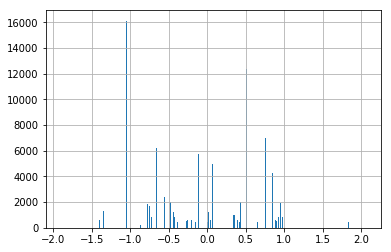

In [175]:
tmp.longitude.hist(bins=1000)

In [106]:
from scipy.special import erfinv

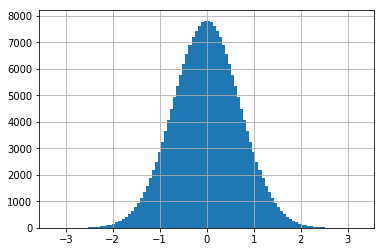

In [112]:
erfinv(tmp).hist(bins=100)

In [6]:
df = pd.concat([train, test])

In [15]:
df.air_store_id.value_counts()

air_5c817ef28f236bdf    516
air_a083834e7ffe187e    515
air_36bcf77d3382d36e    515
air_d97dabf7aae60da5    515
air_60a7057184ec7ec7    514
air_232dcee6f7c51d37    514
air_71903025d39a4571    514
air_7a946aada80376a4    513
air_883ca28ef0ed3d55    513
air_d0e8a085d8dc83aa    512
air_4cca5666eaf5c709    512
air_cb7467aed805e7fe    512
air_6b15edd1b4fbb96a    511
air_3c05c8f26c611eb9    511
air_fe22ef5a9cbef123    511
air_04341b588bde96cd    511
air_dea0655f96947922    511
air_39dccf7df20b1c6a    510
air_7cf5a02c0e01b647    510
air_ba495cccc8f0f237    510
air_2b8b29ddfd35018e    509
air_8c119d1f16049f20    509
air_287d2de7d3c93406    509
air_536043fcf1a4f8a4    509
air_e270aff84ac7e4c8    509
air_f6b2489ccf873c3b    509
air_640cf4835f0d9ba3    509
air_638c35eb25e53eea    509
air_93ebe490d4abb8e9    508
air_4d71826793c09b22    508
                       ... 
air_1f34e9beded2231a    187
air_fb44f566d4f64a4e    173
air_ef47430bcd6f6a89    171
air_e42bdc3377d1eee7    162
air_965b2e0cf4119003

In [19]:
df.visit_date = pd.to_datetime(df.visit_date)

In [31]:
df.shape

(284127, 58)

In [33]:
df[(df.visit_date > '2016-04-23') & (df.visit_date < '2016-05-31')].air_store_id.value_counts()

air_1e23210b584540e7    37
air_aa0049fe3cc6f4d6    37
air_04341b588bde96cd    37
air_671b4bea84dafb67    37
air_506fe758114df773    37
air_5e939e005bd34633    37
air_622375b4815cf5cb    37
air_93b9bb641f8fc982    37
air_93ebe490d4abb8e9    37
air_d0e8a085d8dc83aa    37
air_4cca5666eaf5c709    37
air_383f5b2f8d345a49    37
air_23ee674e91469086    37
air_dea0655f96947922    37
air_b1d822f75c9fc615    37
air_640cf4835f0d9ba3    37
air_c31472d14e29cee8    37
air_7cf5a02c0e01b647    37
air_4570f52104fe0982    37
air_cb7467aed805e7fe    37
air_638c35eb25e53eea    37
air_232dcee6f7c51d37    37
air_8c119d1f16049f20    37
air_8093d0b565e9dbdf    37
air_e270aff84ac7e4c8    37
air_03963426c9312048    37
air_d97dabf7aae60da5    37
air_c9ed65554b6edffb    37
air_a083834e7ffe187e    37
air_68301bcb11e2f389    37
                        ..
air_3a8a3f8fb5cd7f88    24
air_55390f784018349a    24
air_e58f669b6f1a08ce    23
air_4ce7b17062a1bf73    23
air_df5cf5cd03eb68d0    23
air_5ed3198e4a5eed0f    23
a

In [23]:
df.visit_date['2016-04-23':'2016-05-31']

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [2016-04-23] of <class 'str'>

In [16]:
df[df.air_store_id=='air_900d755ebd2f7bbd']

,air_area_name,air_area_name0,air_area_name1,air_area_name2,air_area_name3,air_area_name4,air_area_name5,air_area_name6,air_area_name7,air_area_name8,air_area_name9,air_area_name_target,air_genre_name,air_genre_name0,air_genre_name1,air_genre_name2,air_genre_name3,air_genre_name4,air_genre_name5,air_genre_name6,air_genre_name7,air_genre_name8,air_genre_name9,air_genre_name_target,air_store_id,air_store_id2,air_store_id_target,count_observations,date_int,day_of_week,dow,holiday_flg,id,latitude,lon_plus_lat,longitude,max_visitors,mean_visitors,median_visitors,min_visitors,month,rs1_x,rs1_y,rs2_x,rs2_y,rv1_x,rv1_y,rv2_x,rv2_y,split,total_reserv_dt_diff_mean,total_reserv_mean,total_reserv_sum,var_max_lat,var_max_long,visit_date,visitors,year
158186,45,7.0,6.0,4.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,2.755240,6,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.881236,air_900d755ebd2f7bbd,453,NaN,4.0,20170302,4,3,0,air_900d755ebd2f7bbd_2017-03-02,35.672114,175.44294,139.770825,4.718499,3.840086,4.516205,1.609438,3,37.0,-1.0,3.700000,-1.0,32.0,-1.0,3.200000,-1.0,train,-1.000000,-1.000000,-1.0,8.348518,4.502573,2017-03-02,1.609438,2017
158187,45,7.0,6.0,4.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,2.755240,6,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.881236,air_900d755ebd2f7bbd,453,NaN,4.0,20170401,2,5,0,air_900d755ebd2f7bbd_2017-04-01,35.672114,175.44294,139.770825,4.718499,4.310006,4.325162,3.871201,4,9.0,7.0,2.250000,7.0,9.0,2.0,2.250000,2.0,train,4.625000,2.125000,11.0,8.348518,4.502573,2017-04-01,3.871201,2017
158188,45,7.0,6.0,4.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,2.755240,6,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.881236,air_900d755ebd2f7bbd,453,NaN,3.0,20170402,3,6,0,air_900d755ebd2f7bbd_2017-04-02,35.672114,175.44294,139.770825,4.158883,4.032681,4.007333,3.931826,4,19.0,-1.0,2.714286,-1.0,18.0,-1.0,2.571429,-1.0,train,-1.000000,-1.000000,-1.0,8.348518,4.502573,2017-04-02,4.007333,2017
158189,45,7.0,6.0,4.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,2.755240,6,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.881236,air_900d755ebd2f7bbd,453,NaN,3.0,20170404,5,1,0,air_900d755ebd2f7bbd_2017-04-04,35.672114,175.44294,139.770825,4.543295,4.418685,4.382027,4.330733,4,3.0,-1.0,0.600000,-1.0,13.0,-1.0,2.600000,-1.0,train,-1.000000,-1.000000,-1.0,8.348518,4.502573,2017-04-04,4.382027,2017
158190,45,7.0,6.0,4.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,2.755240,6,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.881236,air_900d755ebd2f7bbd,453,NaN,3.0,20170405,6,2,0,air_900d755ebd2f7bbd_2017-04-05,35.672114,175.44294,139.770825,4.836282,4.666685,4.744932,4.418841,4,7.0,-1.0,3.500000,-1.0,16.0,-1.0,8.000000,-1.0,train,-1.000000,-1.000000,-1.0,8.348518,4.502573,2017-04-05,4.418841,2017
158191,45,7.0,6.0,4.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,2.755240,6,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.881236,air_900d755ebd2f7bbd,453,NaN,4.0,20170406,4,3,0,air_900d755ebd2f7bbd_2017-04-06,35.672114,175.44294,139.770825,4.718499,3.840086,4.516205,1.609438,4,12.0,-1.0,3.000000,-1.0,19.0,-1.0,4.750000,-1.0,train,-1.000000,-1.000000,-1.0,8.348518,4.502573,2017-04-06,4.499810,2017
158192,45,7.0,6.0,4.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,2.755240,6,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.881236,air_900d755ebd2f7bbd,453,NaN,3.0,20170407,0,4,0,air_900d755ebd2f7bbd_2017-04-07,35.672114,175.44294,139.770825,4.744932,4.623238,4.682131,4.442651,4,79.0,-1.0,8.777778,-1.0,36.0,-1.0,4.000000,-1.0,train,-1.000000,-1.000000,-1.0,8.348518,4.502573,2017-04-07,4.442651,2017
158193,45,7.0,6.0,4.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,2.755240,6,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.881236,air_900d755ebd2f7bbd,453,NaN,4.0,20170408,2,5,0,air_900d755ebd2f7bbd_2017-04-08,35.672114,175.44294,139.770825,4.718499,4.310006,4.325162,3.871201,4,53.0,16.0,4.818182,16.0,39.0,14.0,3.545455,14.0,train,10.409091,8.772727,53.0,8.348518,4.502573,2017-04-08,4.219508,2017
158194,45,7.0,6.0,4.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,2.755240,6,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.881236,air_900d755ebd2f7bbd,453,NaN,3.0,20170409,3,6,0,air_900d755ebd2f7bbd_2017-04-09,35.672114,175.44